# HexaCopter
Simulation model of the hexacopter.
Motion of the hexacopter follows to the Linerized Equation of Motion:
$$\ddot{a}=E\omega+g$$
        where $a$ is the state vector: $a = [\begin{matrix}z & \phi & \theta & \psi \end{matrix}]$, $z$ z is the vertical position [m] with downward direction, $\phi$, $\theta$ and $\psi$ are the body angles [rad] with respect to the x, y, z axis respectively, $E$ is a actuator mixing matrix which describes how the actuators(rotors) mix to affect the controllable degrees of freedom, $\omega$ is the vector of rotor speeds [rad/s] and $g$ is gravity acceleration.<br />
Integration of the equation for updating the state vector is calculated with the Runge-kutta method.
<img src="fig/MkHexaXLModel.png",alt="Hexacopter", width=300,height=300>

In [12]:
import numpy as np

class Hxcopter:
    """Linearized simulation model of Hexacopter.
    
     Integration of the equation of motion for updating the state vector is calculated with Runge-Kutta method.
     The control signal is the rotor command vector.
     """
    
    g = 9.81 # gravity coefficient [ m/s^2]
    m = 2.1 # mass [kg]
    L = 0.34 # Distance of rotor from CG [m]
    I = (0.061, 0.060, 0.12) # moments of inertia (Ixx, Iyy, Izz) [kg*m^2]
    kT = 2.3 * 10 ** (-5) # propeller thrust [rad^2/sec^2]
    kQ = 7 * 10 ** (-7) # torque coefficients [rad^2/sec^2]
    
    def __init__(self, dt, omega0):
        """Initializes the hexacopter with simulation setting and initial parameter.
        
        Parameters
        ----------
        dt : float
            The simulation step width [sec]

        omega0 : float
            The initial rotor speed [rad/s]
            All rotors are initially set to omega0.
        """
        
        # simulation time step [sec]
        self.dt = dt
        
        # simulation model list of rotors
        self.rotors = [Rotor(dt, omega0),
                                Rotor(dt, omega0),
                                Rotor(dt, omega0),
                                Rotor(dt, omega0),
                                Rotor(dt, omega0),
                                Rotor(dt, omega0)]
        
        # altitude [m], roll, pitch, yaw [rad]
        self.state = np.array([0.0, 0.0, 0.0, 0.0])
        
        # vertical speed [m/s], roll, pitch, yaw speed [rad/sec]
        self.velocity = np.array([0.0, 0.0, 0.0, 0.0])
        
        # Matrix of EOM
        Ew = (- self.kT / self.m) * np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
        Ep = (1.73 * self.L * self.kT / 2 / self.I[0]) * np.array([0, -1.0, -1.0, 0, 1.0, 1.0])
        Eq = (self.L * self.kT / self.I[1]) * np.array([1.0, 0.5, -0.5, -1.0, -0.5, 0.5])
        Er = (self.kQ / self.I[2]) * np.array([-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, ])
        self.E = np.array([Ew, Ep, Eq, Er])
    
    
    def get_state(self):
        """Returns the state vector as below:
        
        s = [z phi theta psi]
        , where z is the vertical position with downward direction and,
        phi, theta and psi are body angles [rad] with positive clockwise
        around the x, y, z axis respectively.
        
        Returns
        -------
        state : [float, float, float, float]
        """
        
        return self.state
    
    
    def get_velosity(self):
        """Returns the velocity vector as below:
        
        ds/dt = [w p q r]
        where w is the vertical velocity [m/s] with downward direction,
        and p, q, and q are the body angle speed [rad/s] with positive clockwise
        around the x, y and z axis respectively.
        
        Returns
        -------
        state : [float, float, float, float]
        """
        
        return self.velocity
   

    def func(self, x, y):
        """Equation of Motion of hexacopter.
        
        Parameter
        ----------
        x : [float, float, float, float]
            State vector
            
        y : [float, float, float, float]
            Velocity vector
        
        Returns
        -------
        dx : [float, float, float, float]
            Increment of the state vector
            
        dy : [float, float, float, float]
            Increment of the velocity vector
        """
        
        # get current rotor speeds
        o = np.array([0, 0, 0, 0, 0, 0])
        for i in range(6):
            o[i] = self.rotors[i].o
        
        # d(state)/dt = velocity
        dx = y
        # d(velocity)/dt = E*omega^2 + g
        dy = self.E.dot(o * o) + np.array([self.g, 0.0, 0.0, 0.0])
        
        return dx, dy
    
    
    def update(self):
        """Develops the simulation of the hexacopter atitude with Runge-Kutta method."""
        
        # updates speed of all rotors
        for r in self.rotors:
            r.update()
            
        # Runge-Kutta scheme
        kx1, ky1= self.func(self.state, self.velocity)
        kx2, ky2 = self.func(self.state + kx1 * self.dt / 2, self.velocity + ky1 * self.dt / 2)
        kx3, ky3 = self.func(self.state + kx2 * self.dt / 2, self.velocity + ky2 * self.dt / 2)
        kx4, ky4 = self.func(self.state + kx3 * self.dt, self.velocity + ky3 * self.dt)
        self.velocity += (ky1 + 2 * ky2 + 2 * ky3 + ky4) * self.dt / 6
        self.state += (kx1 + 2 * kx2 + 2 * kx3 + kx4) * self.dt / 6
        return self.state
    
    
    def set_rotor_speed(self, cmds):
        """Sets rotor speeds to control the atitude.
        
        Parameter
        ----------
        cmds : [float, float, float, float, float, float]
            Rotor speed set points
        """
        
        for i in range(6):
            self.rotors[i].set_speed(cmds[i])

## Rotor
Simulation model of the rotor.
The rotor speed is assumed that bandwidth of the controlled motor/propeller pair can be modeled by as simple lag filter as below:
$$\dot{\omega}=\frac{1}{\tau}(\omega_{cmd}-\omega)$$
where $\omega$ is the rotor speed [rad/s], $\tau$ is a time constant and $\omega_{cmd}$ is the speed commond.

In [8]:
class Rotor:
    """Simulation model of the response of the rotor speed.
    
    The rotor speed is emulated the first-order lag system.
    """
    
    tau = 0.15 # motor time constant
    
    def __init__(self, dt, omega0):
        """Initializes the rotor with the initial rotor speed.
        
        Parameters
        ----------
        dt : float
            The simulation step width [sec]
            
        omega0 : float
            The initial rotor speed [rad/s]
        """
        
        # simulation time step width
        self.dt = dt
        
        # omega = rotor speed
        self.o = omega0
        
        # speed commond
        self.cmd = omega0
    
    
    def func(self, o):
        """Equation of the first-order lag system of the rotor.
        
        Parameters
        ----------
        o : float
            The current rotor speed
        """
        
        return (self.cmd - o) / self.tau
    
    
    def update(self):
        """Develops the simulation of the rotor with Runge-Kutta method."""
        
        # Runge-Kutta scheme
        k1 = self.func(self.o)
        k2 = self.func(self.o + k1 * self.dt / 2)
        k3 = self.func(self.o + k2 * self.dt / 2)
        k4 = self.func(self.o + k3 * self.dt)
        self.o += (k1 + 2 * k2 + 2 * k3 + k4) * self.dt / 6
        return self.o
    
    
    def set_speed(self, cmd):
        """Set the rotor speed command.
        
        Parameters
        ----------
        cmd : float
            The speed command [rad/s]
        """
        
        self.cmd = cmd

### Test of Hexacopter and Rotor models

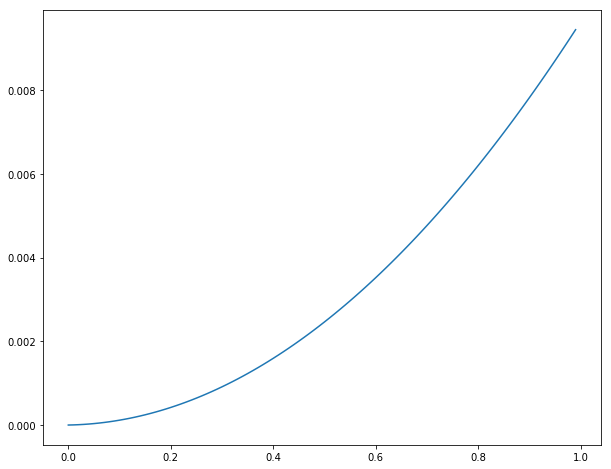

In [17]:
import matplotlib.pyplot as plt

# Display plots inline and change default figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# simulation time step width [sec]
dt = 0.01
# simulation time [sec]
runtime = 1
# number of the simulation step
num_step = int(runtime / dt)

# plant setting
# initial rotor speed [rpm]
omega0 = 386.4
# create hexacopter model
hx = Hxcopter(dt, omega0)


# log
data = np.zeros(num_step)

# simulation
for t in range(num_step):
    hx.update()
    data[t] = hx.get_state()[0]
    
# draw graph of vertical speed log
t = np.arange(0, runtime, dt)
plt.plot(t, data)

## PID
Basic PID unit.

In [17]:
class PID:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.ei = 0.0
        self.pe = 0.0
    
    def update(self, x, y):
        e = x - y
        self.ei = e
        ed = e - self.pe
        u = self.Kp * e + self.Ki * self.ei + self.Kd * ed
        self.pe = e
        return u

## PID controller for Hexa Copter
The linearized transfer function of the hexacopter is written as below:
$$\bigg\{
\begin{array}{l}
\omega=\frac{1}{\tau s+1}\omega_{cmd}\\
a=2\omega_0E\omega
\end{array}
$$

In [98]:
class HxController:
    g = 9.81 # gravity coefficient [ m/s^2]
    m = 2.1 # mass [kg]
    L = 0.34 # Distance of rotor from CG [m]
    I = (0.061, 0.060, 0.12) # moments of inertia (Ixx, Iyy, Izz) [kg*m^2]
    kT = 2.3 * 10 ** (-5) # propeller thrust [rad^2/sec^2]
    kQ = 7 * 10 ** (-7) # torque coefficients [rad^2/sec^2]
    
    def __init__(self, pids):
        self.pids = pids
        ew = - self.m / 6 / self.kT
        ep = 1.73 * self.I[0] / 6 / self.kT
        eq = self.I[1] / 3 / self.L / self.kT
        er = self.I[2] / 6 / self.kQ
        e1 = np.array([ew, 0, eq, - er])
        e2 = np.array([ew, ep, eq / 2, er])
        e3 = np.array([ew, ep, - eq / 2, - er])
        e4 = np.array([ew, 0, - eq, er])
        e5 = np.array([ew, - ep, - eq / 2, - er])
        e6 = np.array([ew, - ep, eq / 2, er])
        self.Einv = np.array([e1, e2, e3, e4, e5, e6])
        
    def update(self, cmds, states):
        us = np.array([0.0, 0.0, 0.0, 0.0]) 
        for i in range(4):
            x = cmds[i]
            y = states[i]
            us[i] = pids[i].update(x, y)
        return self.Einv.dot(us)